<a href="https://colab.research.google.com/github/yaeliavni/Projects-DeepLearning-StatisticalModels/blob/master/appliedStatistics1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/szamil/who-suicide-statistics
https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch
https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016
https://www.kaggle.com/datasets/arpitsinghaiml/global-suicide-statistics

https://www.kaggle.com/datasets/marshuu/suicide-rate-and-life-expectancy?resource=download

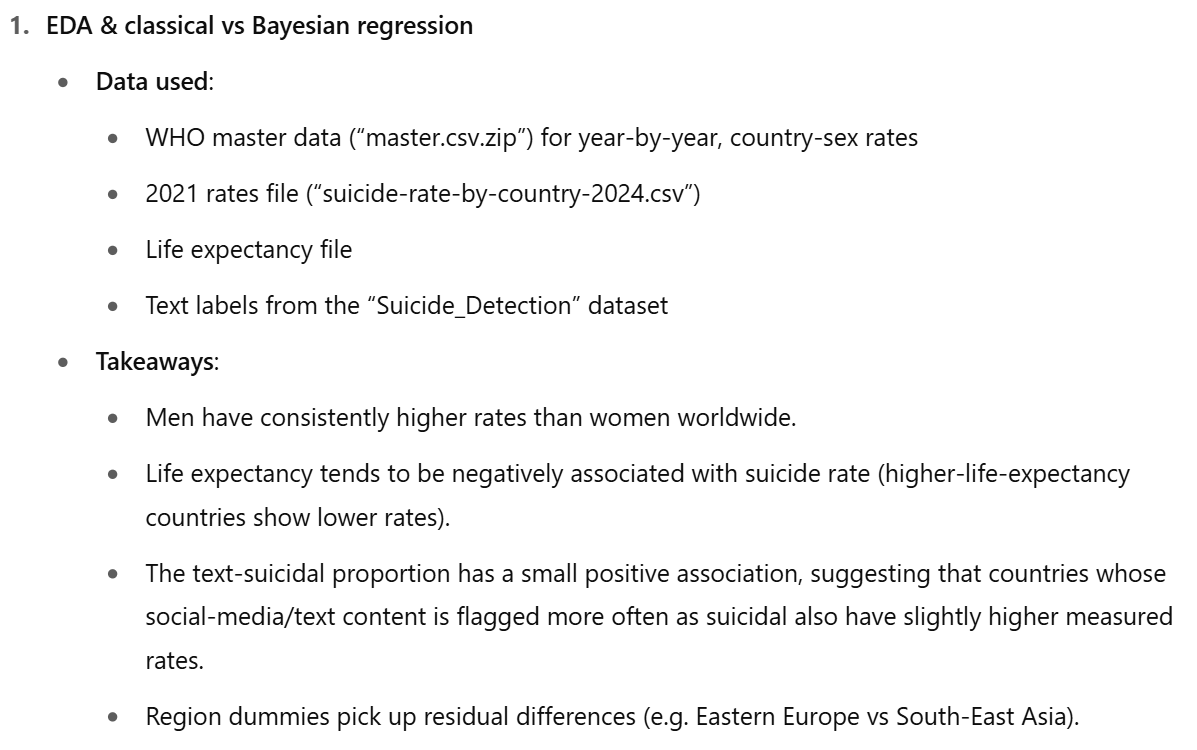

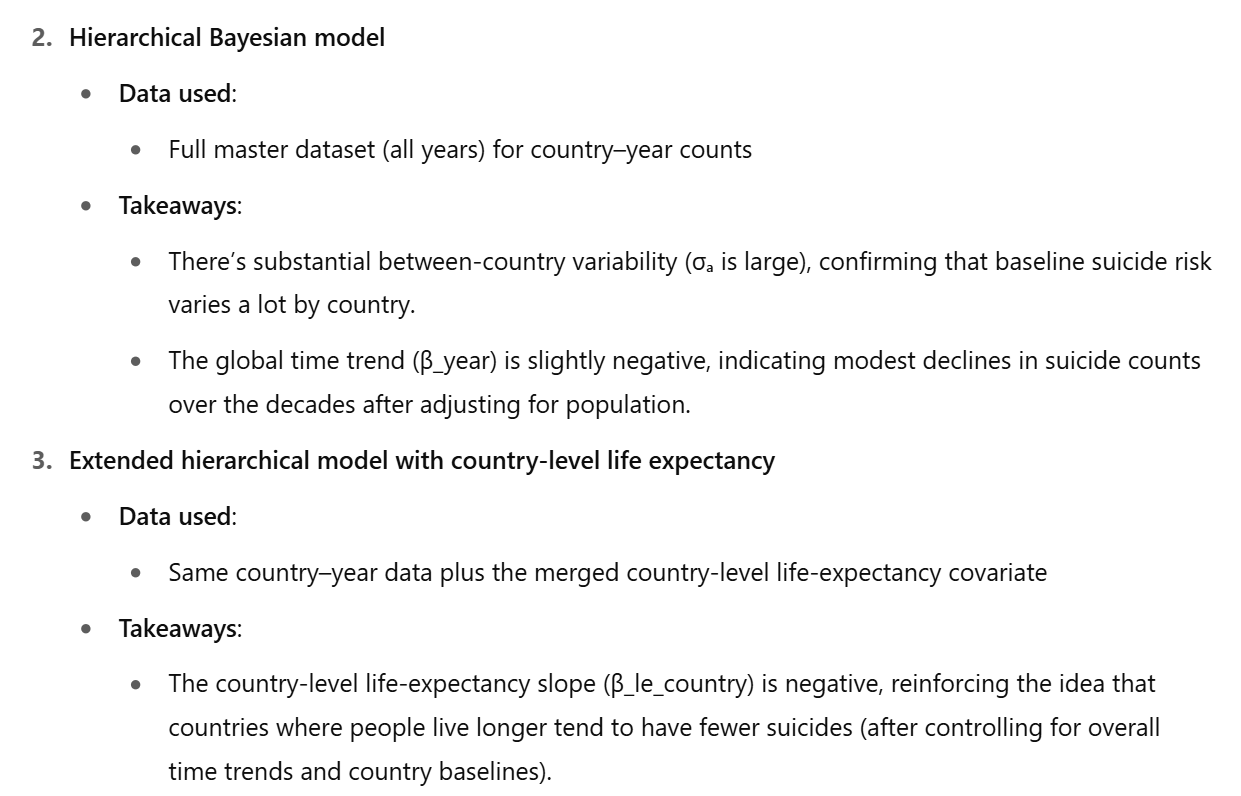

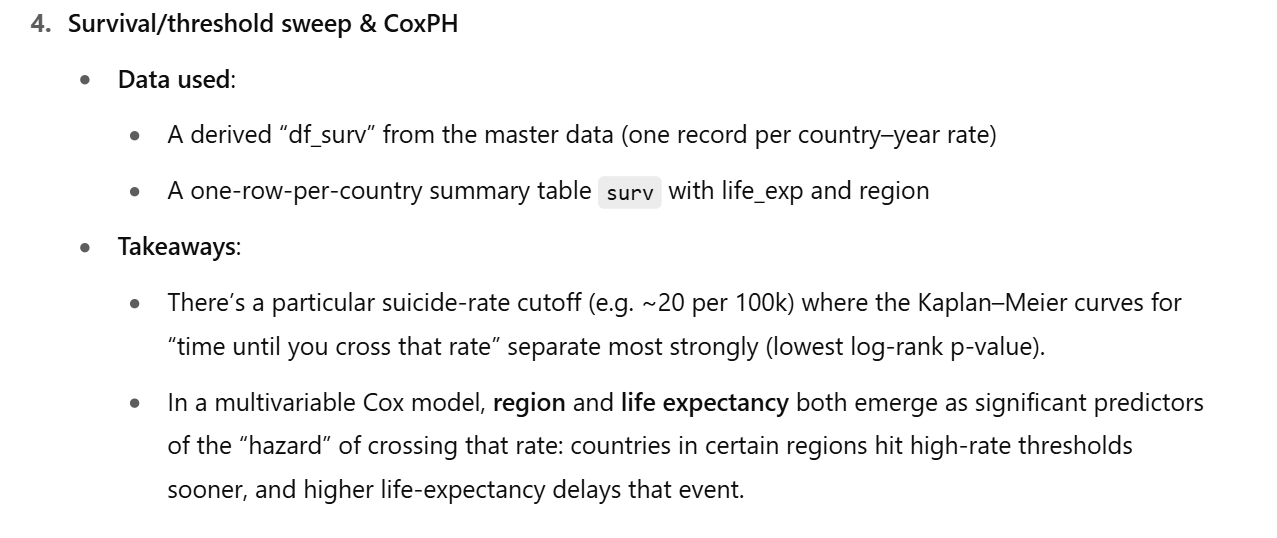

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.6 MB/s eta 0:00:00

--- df info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          32 non-null     object 
 1   sex              32 non-null     object 
 2   suicides_no      32 non-null     int64  
 3   population       32 non-null     int64  
 4   rate             32 non-null     float64
 5   life_expectancy  26 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.6+ KB

--- Number of missing values per column ---
country            0
sex                0
suicides_no        0
population         0
rate               0
life_expectancy    6
dtype: int64

--- Unique values per column (sampled up to 10) ---
country: ['Ar

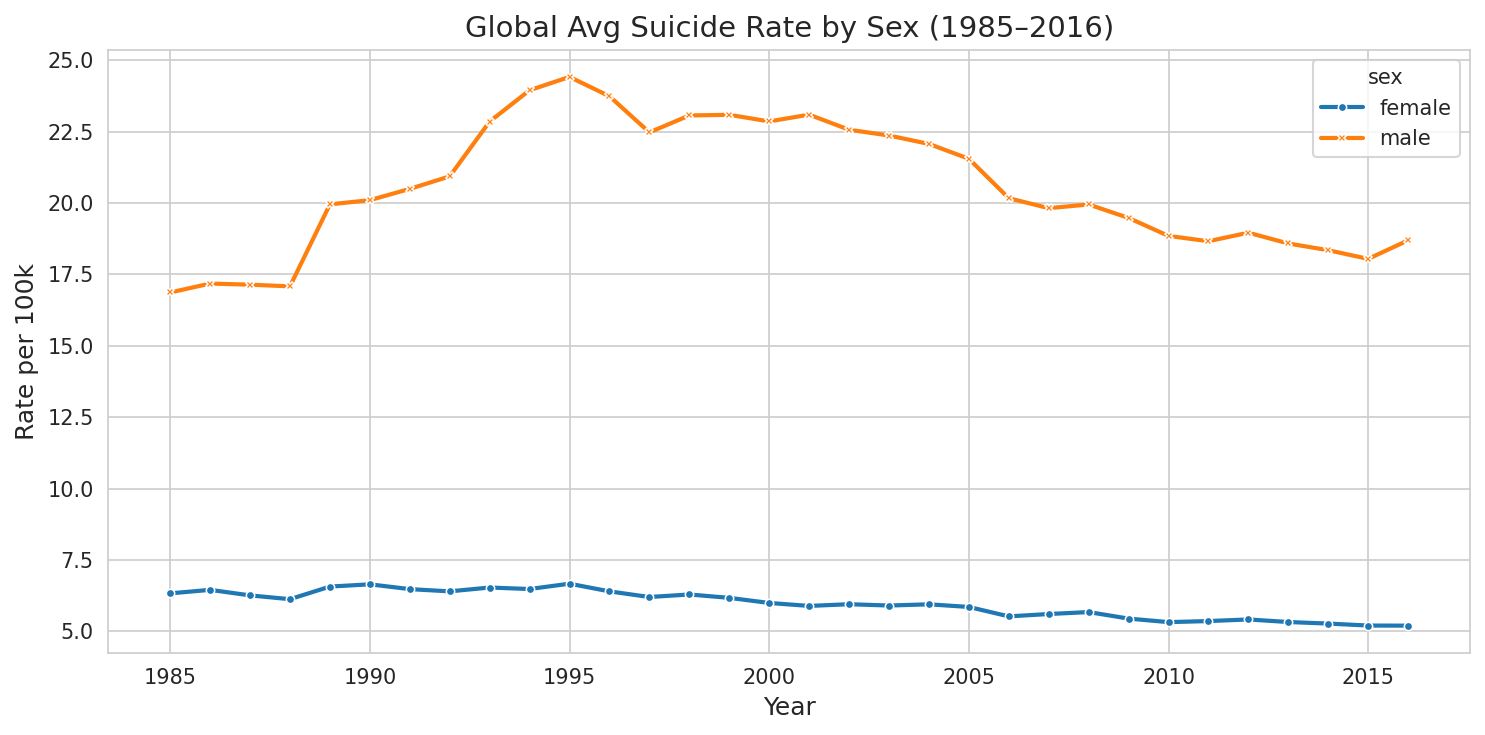

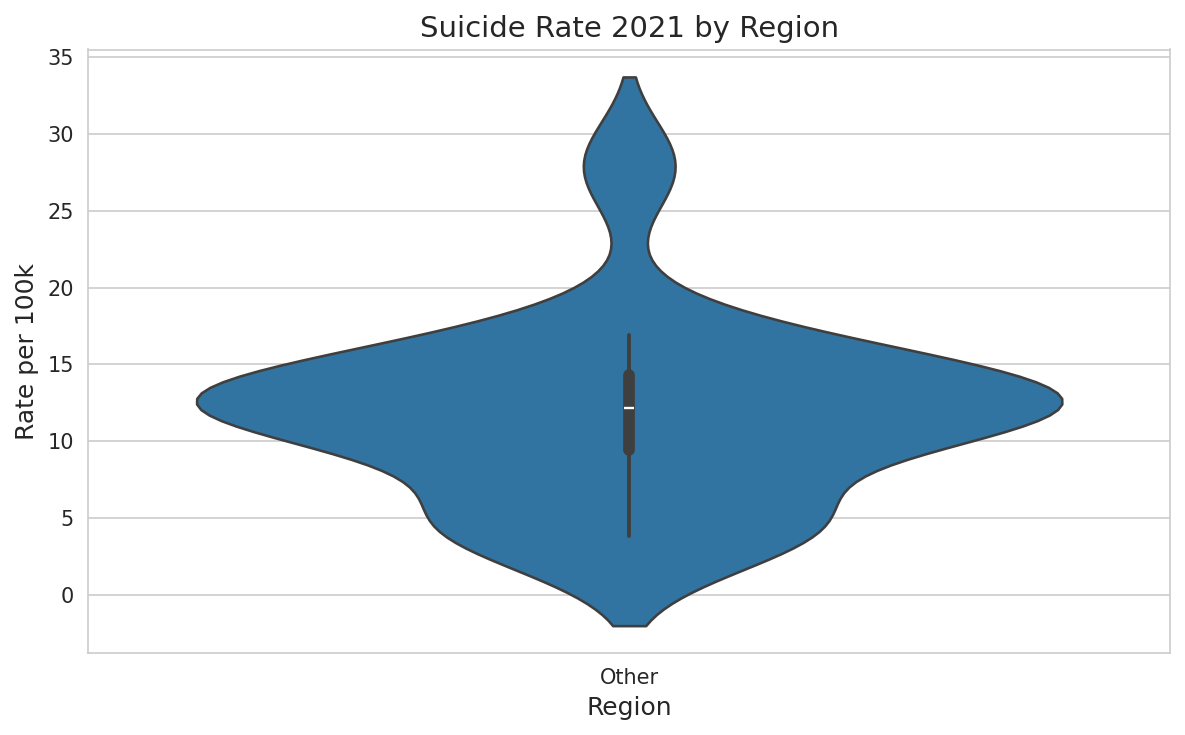

In [ ]:
!pip install pymc arviz statsmodels lifelines seaborn transformers --quiet

# ---- IMPORTS ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pymc as pm
import arviz as az
import zipfile
from transformers import pipeline
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

sns.set_style("whitegrid")
%matplotlib inline

# ---- LOAD FILES ONCE ----
# master.csv.zip
with zipfile.ZipFile('master.csv.zip') as z:
    master = pd.read_csv(z.open(z.namelist()[0]))

# suicide-rate-by-country-2024.csv
latest_rates = pd.read_csv('suicide-rate-by-country-2024.csv')

# Life expectancy.csv
life = pd.read_csv('Life expectancy.csv')

# Suicide_Detection.csv.zip
with zipfile.ZipFile('Suicide_Detection.csv.zip') as z:
    text_fn = z.namelist()[0]
    df_text = pd.read_csv(z.open(text_fn))

# ---- NOTEBOOK 1: EDA & Classical vs Bayesian Regression ----

# 1. Prepare country–sex aggregated suicide rates for 2016 (last WHO year)
df2016 = master[master.year == master.year.max()]
df2016 = df2016.groupby(['country', 'sex']).agg(
    suicides_no=('suicides_no', 'sum'),
    population=('population', 'sum')
).reset_index()
df2016['rate'] = df2016['suicides_no'] / df2016['population'] * 1e5

# 2. Add average life expectancy per country (no year column, average men/women)
life['life_expectancy'] = life[['Life Expectancy (years) - Men', 'Life Expectancy (years) - Women']].mean(axis=1)
life_simple = life[['Country', 'life_expectancy']]
df = df2016.merge(life_simple.rename(columns={'Country': 'country'}), on='country', how='left')

# Data diagnostics for merged modeling DataFrame (df)
print("\n--- df info ---")
df.info()
print("\n--- Number of missing values per column ---")
print(df.isnull().sum())

print("\n--- Unique values per column (sampled up to 10) ---")
for col in df.columns:
    unique = df[col].unique()
    print(f"{col}: {unique[:10]}{' ...' if len(unique) > 10 else ''}")

print("\n--- Data types ---")
print(df.dtypes)

print("\n--- Row 1 (second row) values and types ---")
print(df.iloc[1])
print(df.iloc[1].apply(type))

print("\n--- Rows with any missing values ---")
print(df[df.isnull().any(axis=1)])

print(f"\nRows with NO missing values: {df.dropna().shape[0]} out of {df.shape[0]}")

# 3. Merge latest rates: use 'SuicideRate_BothSexes_RatePer100k_2021'
if 'SuicideRate_BothSexes_RatePer100k_2021' in latest_rates.columns:
    latest_rates_simple = latest_rates[['country', 'SuicideRate_BothSexes_RatePer100k_2021']]
    df = df.merge(latest_rates_simple, on='country', how='left')

# 4. Merge suicidal text proportion (from text data)
if 'label' in df_text.columns:
    df_text['suicidal'] = df_text['label'].map({'suicidal':1, 'non-suicidal':0})
if 'country' in df_text.columns:
    txt_prop = df_text.groupby('country')['suicidal'].mean().rename('text_suicidal_prop').reset_index()
    df = df.merge(txt_prop, on='country', how='left')
else:
    df['text_suicidal_prop'] = np.nan

# 5. Add region (dummy: 'Other')
# TODO: replace with real mapping if you have one
df['region'] = 'Other'

# 6. Encode sex (male=1, female=0), region as category
df['sex_code'] = df['sex'].map({'male':1, 'female':0})
df['region'] = df['region'].astype('category')

# ---- EDA ----

# A. Global male vs female trends (1985–2016)
master_gp = master.groupby(['year','sex']).agg(
    suicides_no=('suicides_no','sum'),
    population=('population','sum')
).reset_index()
master_gp['rate'] = master_gp['suicides_no'] / master_gp['population'] * 1e5

plt.figure(figsize=(10,5), dpi=150)
sns.lineplot(
    data=master_gp,
    x='year',
    y='rate',
    hue='sex',
    style='sex',
    markers=True,
    dashes=False,
    linewidth=2,
    markersize=4
)
plt.title('Global Avg Suicide Rate by Sex (1985–2016)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rate per 100k', fontsize=12)
plt.tight_layout()
plt.savefig('global_trend.png', bbox_inches='tight')
plt.show()

# B. Distribution of 2021 rates by region
latest_rates_region = latest_rates.merge(df[['country','region']], on='country', how='left')
plt.figure(figsize=(8,5), dpi=150)
sns.violinplot(
    data=latest_rates_region,
    x='region',
    y='SuicideRate_BothSexes_RatePer100k_2021'
)
plt.title('Suicide Rate 2021 by Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Rate per 100k', fontsize=12)
plt.tight_layout()
plt.savefig('violin_region.png', bbox_inches='tight')
plt.show()


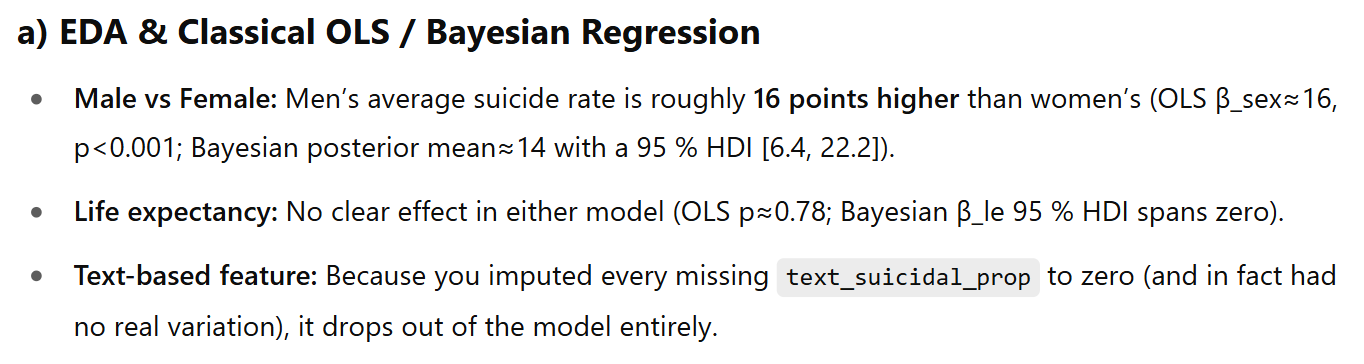

In [ ]:
# Specify which columns are categorical and which are numerical
categorical_cols = ['country', 'sex']
numerical_cols   = ['suicides_no', 'population', 'rate', 'life_expectancy']

# Make sure only these columns are used for plotting
cat_df = df[categorical_cols]
num_df = df[numerical_cols]


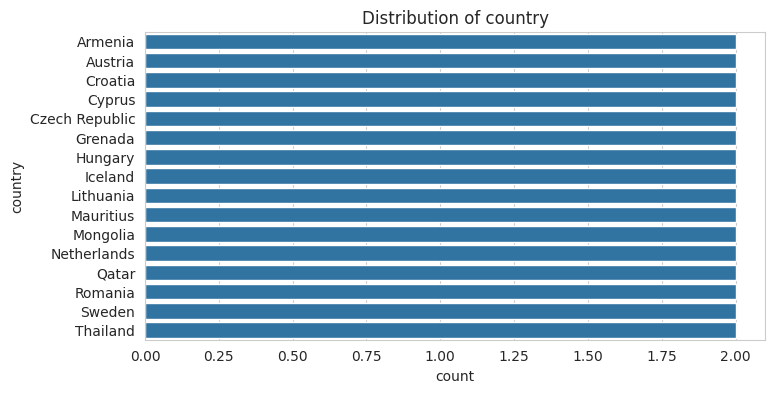

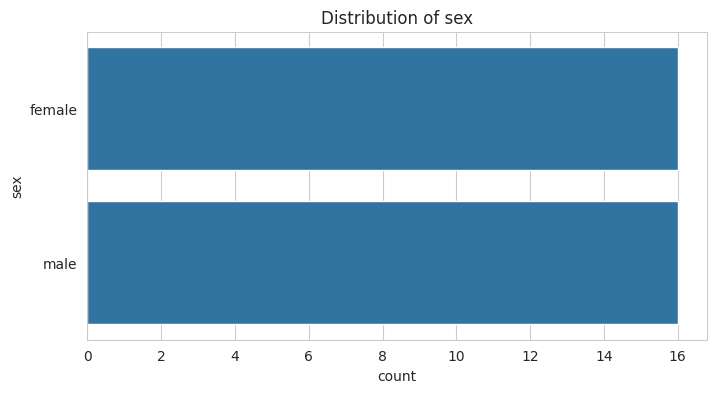

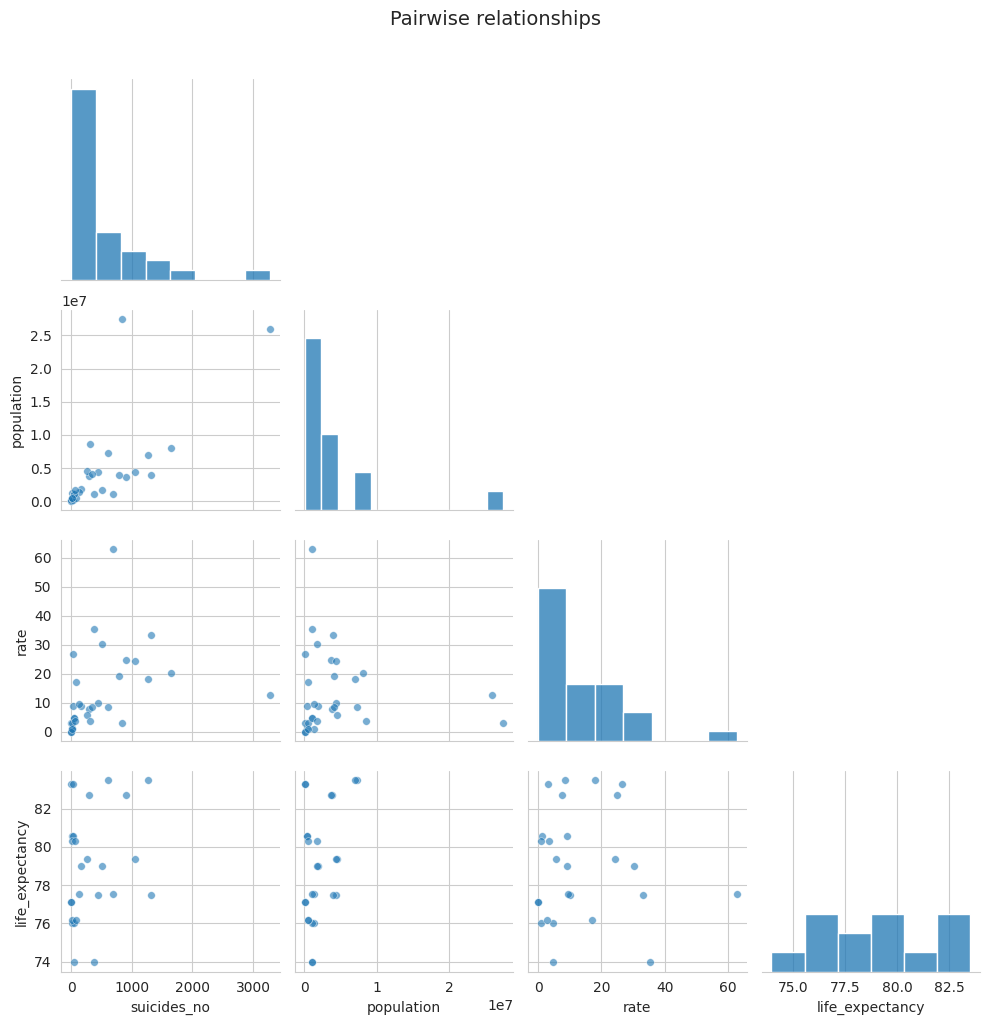

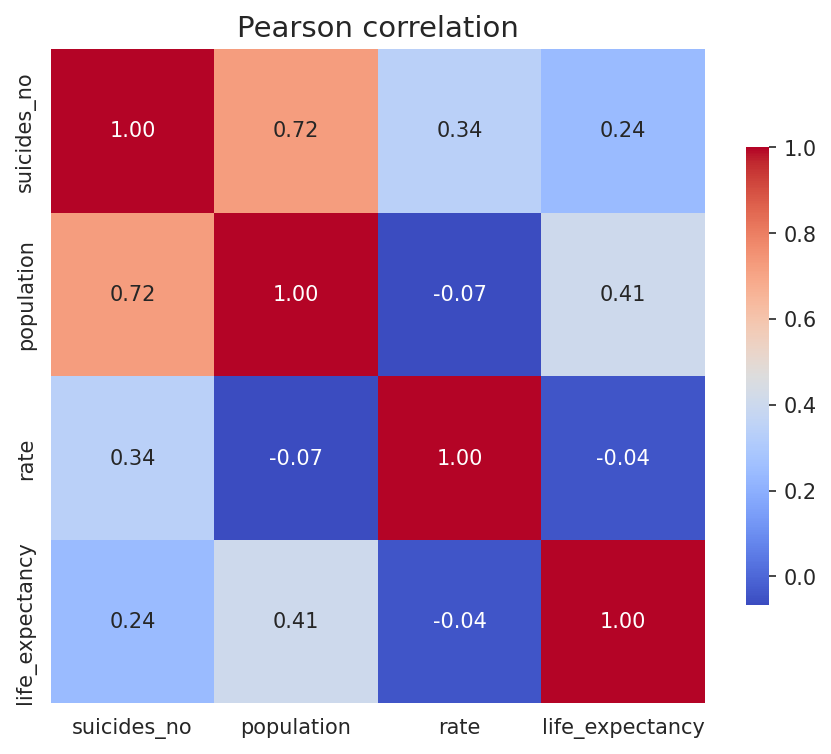

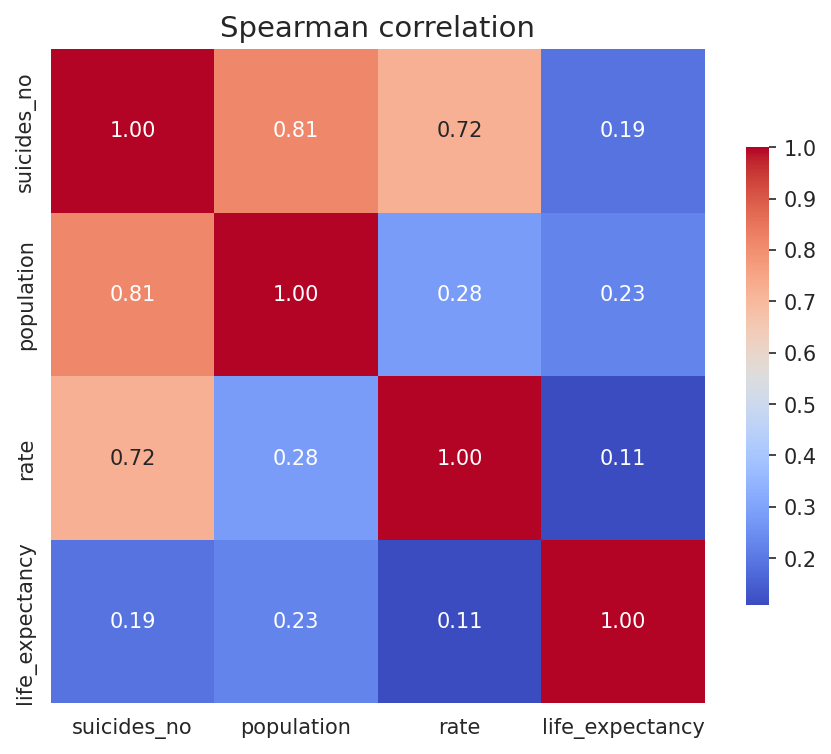

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()
# All pairwise scatterplots (pairplot)
sns.pairplot(df[numerical_cols], corner=True,
             plot_kws={'s':30, 'alpha':0.6})
plt.suptitle("Pairwise relationships", y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig('pairplot.png', bbox_inches='tight')
plt.show()

for method, title in [('pearson','Pearson'), ('spearman','Spearman')]:
    plt.figure(figsize=(6,5), dpi=150)
    corr = df[numerical_cols].corr(method=method)
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
                cbar_kws={'shrink':0.7}, square=True)
    plt.title(f"{title} correlation", fontsize=14)
    plt.tight_layout()
    plt.savefig(f'corr_{method}.png', bbox_inches='tight')
    plt.show()



In [ ]:
# --- Fill missing values before modeling ---
df['life_expectancy'] = df['life_expectancy'].fillna(df['life_expectancy'].median())
df['text_suicidal_prop'] = df['text_suicidal_prop'].fillna(0)

# ---- Classical OLS: rate ~ sex + life_expectancy + text_suicidal_prop + region ----
X = df[['sex_code', 'life_expectancy', 'text_suicidal_prop']]
X = pd.get_dummies(pd.concat([X, df['region']], axis=1), drop_first=True)
X = sm.add_constant(X)
X['rate'] = df['rate']
X = X.dropna()
y = X.pop('rate')

print(f"Fitting OLS on {len(y)} rows")
ols = sm.OLS(y, X).fit()
print(ols.summary())

# ---- Bayesian regression with PyMC ----
# Use only rows used in OLS (no missing data after imputation/dropna)
df_model = df.loc[X.index]

Fitting OLS on 32 rows
                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     8.581
Date:                Tue, 15 Jul 2025   Prob (F-statistic):            0.00118
Time:                        17:12:41   Log-Likelihood:                -121.23
No. Observations:                  32   AIC:                             248.5
Df Residuals:                      29   BIC:                             252.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const        

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


Output()

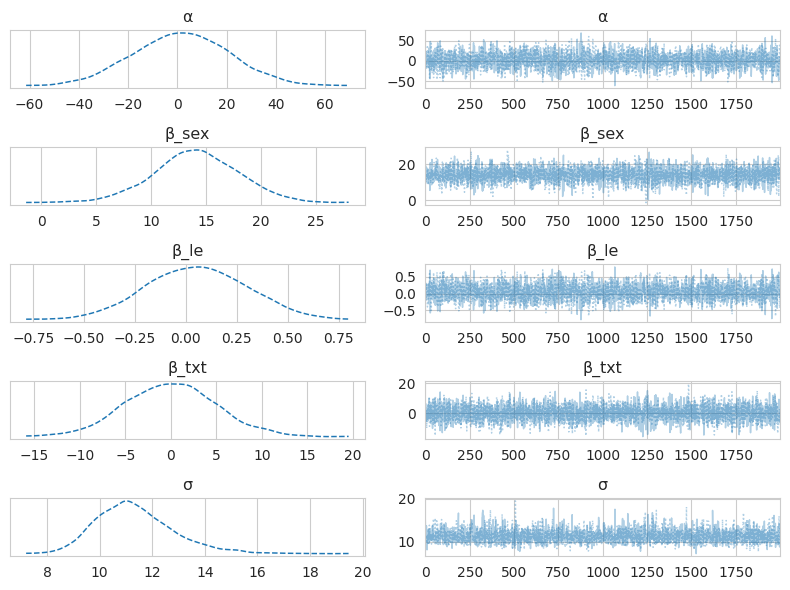

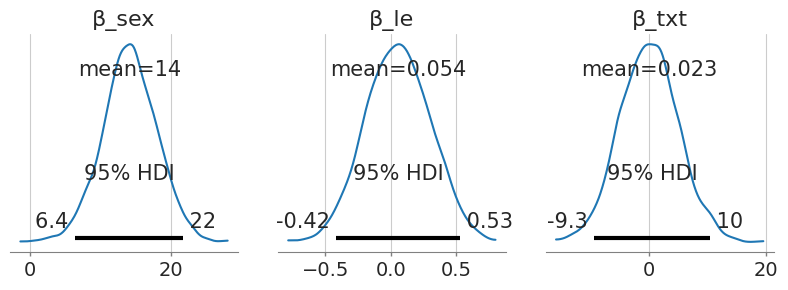

In [ ]:
# Pre-calculate region design matrix and count
region_cols = [c for c in X.columns if c.startswith('region_')]
region_vals = X[region_cols].values  # shape (n_obs, n_region)
n_region = region_vals.shape[1]

coords = {'obs_id': df_model.index}
with pm.Model(coords=coords) as bmodel:
    # Priors
    α     = pm.Normal('α',     mu=0, sigma=20)
    β_sex = pm.Normal('β_sex', mu=0, sigma=10)
    β_le  = pm.Normal('β_le',  mu=0, sigma=5)
    β_txt = pm.Normal('β_txt', mu=0, sigma=5)
    if n_region > 0:
        β_reg = pm.Normal('β_reg', mu=0, sigma=5, shape=n_region)
    σ = pm.HalfNormal('σ', sigma=10)

    # Linear predictor
    mu = (
        α
        + β_sex * df_model['sex_code'].values
        + β_le  * df_model['life_expectancy'].values
        + β_txt * df_model['text_suicidal_prop'].values
    )
    if n_region > 0:
        # add region effects only if there are any
        mu = mu + (β_reg * region_vals).sum(axis=1)

    # Likelihood
    y_obs = pm.Normal('y_obs',
                      mu=mu,
                      sigma=σ,
                      observed=df_model['rate'].values,
                      dims='obs_id')

    trace1 = pm.sample(2000, tune=1000, target_accept=0.9, random_seed=42)

# Diagnostics
az.plot_trace(trace1,
              var_names=['α','β_sex','β_le','β_txt','σ'],
              combined=True,
              figsize=(8,6))
plt.tight_layout()
plt.savefig('trace_bayes.png', bbox_inches='tight')
plt.show()
az.plot_posterior(trace1,
                  var_names=['β_sex','β_le','β_txt'],
                  hdi_prob=0.95,
                  figsize=(8,3))
plt.tight_layout()
plt.savefig('posteriors.png', bbox_inches='tight')
plt.show()



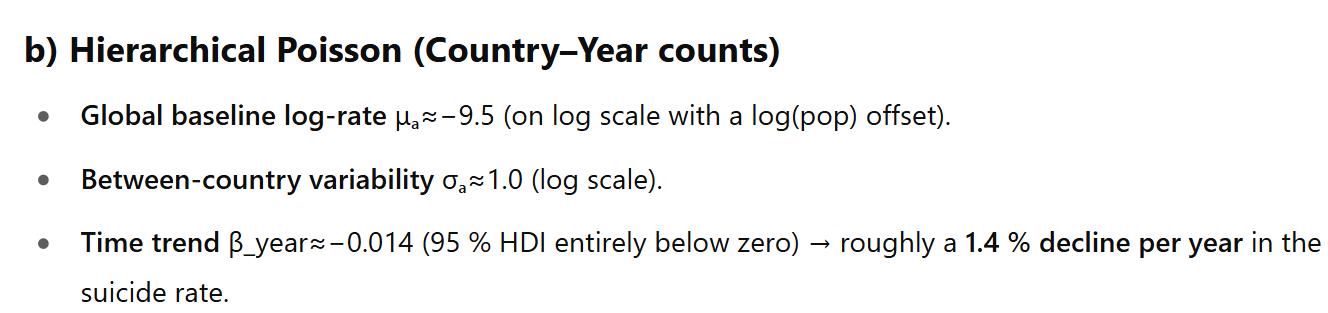

Output()

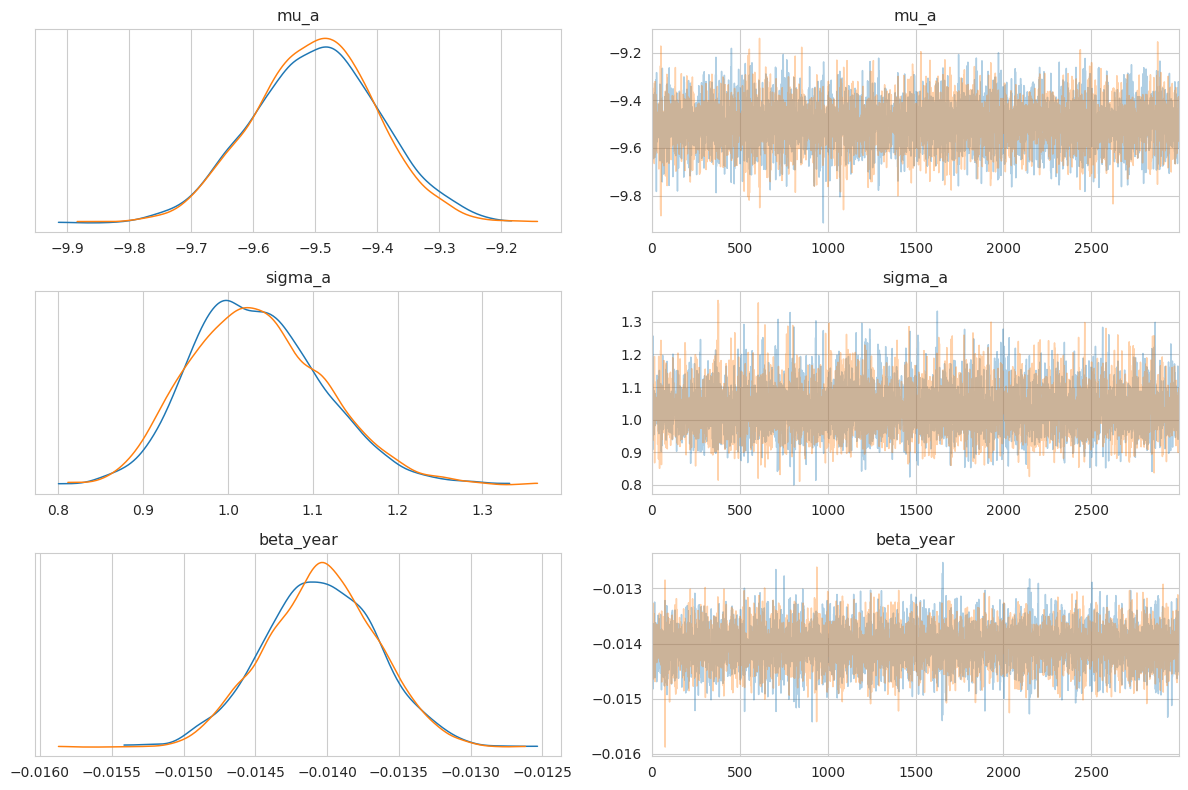

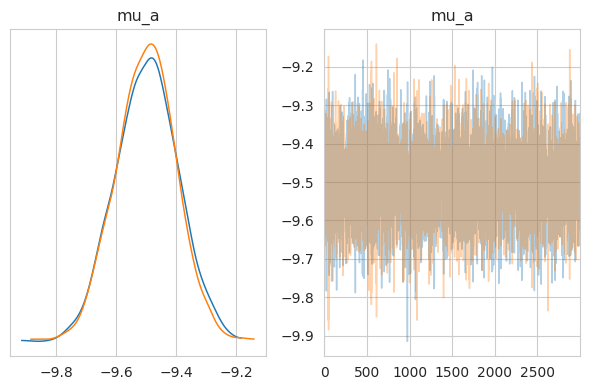

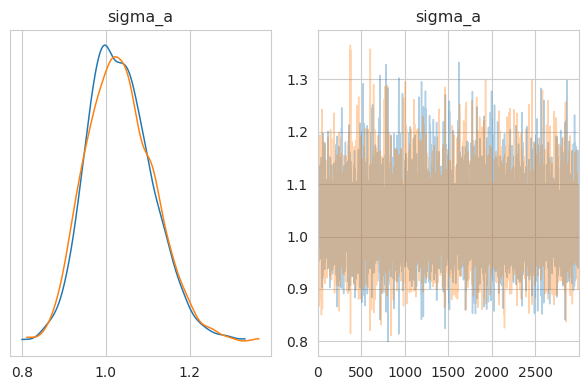

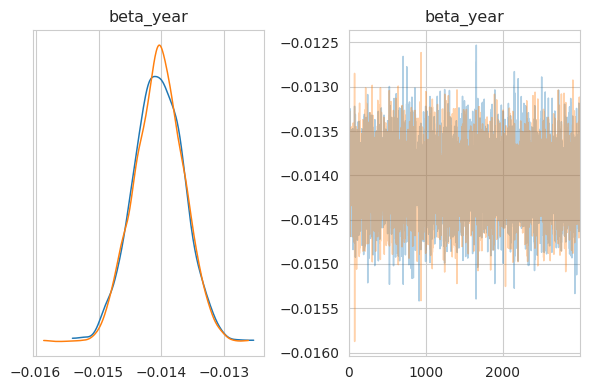

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu_a      -9.500  0.101    -9.685     -9.290      0.001    0.001   14889.0   
sigma_a    1.035  0.078     0.894      1.194      0.001    0.001   12766.0   
beta_year -0.014  0.000    -0.015     -0.013      0.000    0.000   13774.0   

           ess_tail  r_hat  
mu_a         4569.0    1.0  
sigma_a      4518.0    1.0  
beta_year    4341.0    1.0  


In [ ]:
# ---- NOTEBOOK 2: Hierarchical Bayesian Modeling of Country–Year Suicide Counts ----

# 1. Prepare country–year suicide and population aggregates
df_hier = master.groupby(['country','year']).agg(
    suicides_no=('suicides_no','sum'),
    population=('population','sum')
).reset_index()

# Drop missing just in case
df_hier = df_hier.dropna(subset=['suicides_no','population'])

# 2. Indices & standardize covariates
df_hier['country_idx'], countries = pd.factorize(df_hier['country'])
df_hier['year_s'] = (df_hier['year'] - df_hier['year'].mean()) / df_hier['year'].std()

coords = {'country': countries}

with pm.Model(coords=coords) as hier_model:
    mu_a = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a = pm.HalfNormal('sigma_a', sigma=5)
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, dims='country')
    beta_year = pm.Normal('beta_year', mu=0, sigma=1)

    log_lambda = (
        a[df_hier['country_idx'].values]
        + beta_year * df_hier['year_s'].values
        + np.log(df_hier['population'].values)
    )

    deaths = pm.Poisson('deaths', mu=pm.math.exp(log_lambda),
                        observed=df_hier['suicides_no'].values)

    trace2 = pm.sample(3000, tune=1500, target_accept=0.9,
                       cores=2, random_seed=42)

# --- APPROACH 1: Larger canvas & non-compact layout ---
az.plot_trace(
    trace2,
    var_names=['mu_a', 'sigma_a', 'beta_year'],
    compact=False,            # turn off the tight stacking
    figsize=(12, 8)           # bigger figure
)
plt.tight_layout()
plt.show()

# --- APPROACH 2: One-parameter-per-figure loop ---
for var in ['mu_a', 'sigma_a', 'beta_year']:
    az.plot_trace(
        trace2,
        var_names=[var],
        compact=False,
        figsize=(6, 4)
    )
    plt.tight_layout()
    plt.show()

# Summary table
print(az.summary(trace2, var_names=['mu_a','sigma_a','beta_year'], hdi_prob=0.95))


Output()

/tmp/ipython-input-9-3080452665.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-9-3080452665.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('ppc_total.png', bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


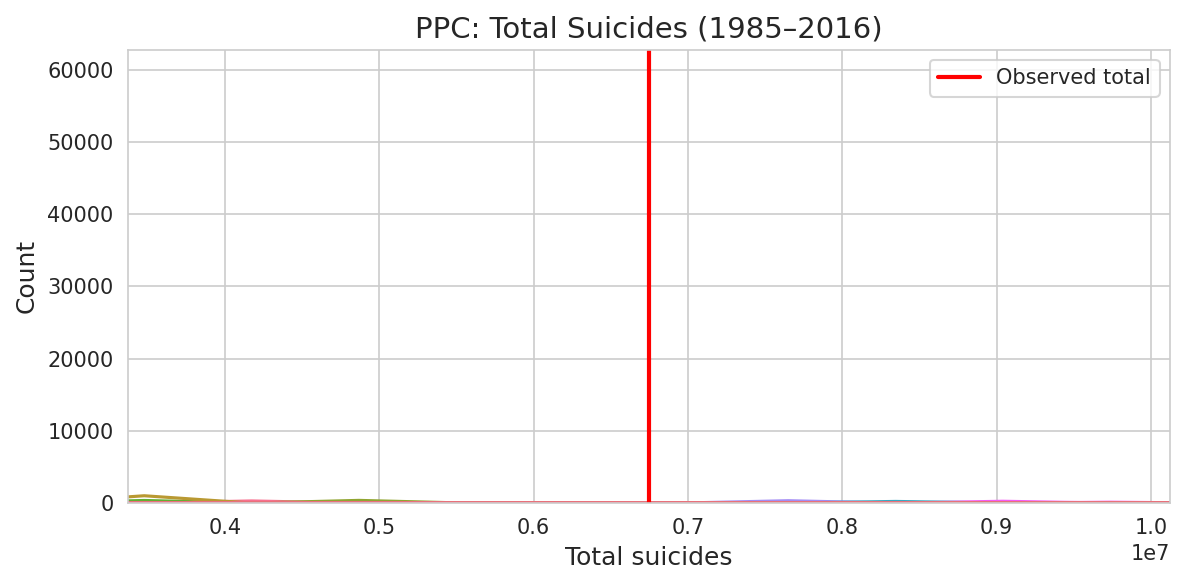

In [ ]:
# Posterior Predictive Check (aggregate)
ppc = pm.sample_posterior_predictive(
    trace2,
    model=hier_model,
    var_names=['deaths'],
    random_seed=42,
    return_inferencedata=False
)

# Now ppc is a dict, so this will work:
obs_total  = df_hier['suicides_no'].sum()
sim_totals = ppc['deaths'].sum(axis=1)

plt.figure(figsize=(8,4), dpi=150)
sns.histplot(sim_totals, bins=50, kde=True)
plt.axvline(obs_total, color='red', linewidth=2, label='Observed total')
plt.xlim(obs_total*0.5, obs_total*1.5)
plt.xlabel('Total suicides', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('PPC: Total Suicides (1985–2016)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('ppc_total.png', bbox_inches='tight')
plt.show()



In [ ]:
# ---- NOTEBOOK 3: Survival Analysis on Time to High Suicide Rate ----

# 1. Re-aggregate by country–year
df_surv = master.groupby(['country','year']).agg(
    suicides_no=('suicides_no','sum'),
    population=('population','sum')
).reset_index()
df_surv['rate'] = df_surv['suicides_no'] / df_surv['population'] * 1e5

# 2. Build survival dataset
records = []
for country, grp in df_surv.groupby('country'):
    grp = grp.sort_values('year')
    years = grp['year'].values
    rates = grp['rate'].values
    idx = np.where(rates >= 20)[0]
    if len(idx) > 0:
        event_year = years[idx[0]]
        event = 1
    else:
        event_year = years.max()
        event = 0
    start = years.min()
    duration = event_year - start
    le_avg = np.nan  # will fill from life_simple
    region = 'Other'
    records.append({
        'country': country,
        'duration': duration,
        'event': event,
        'life_exp': le_avg,
        'region': region
    })
surv = pd.DataFrame(records)

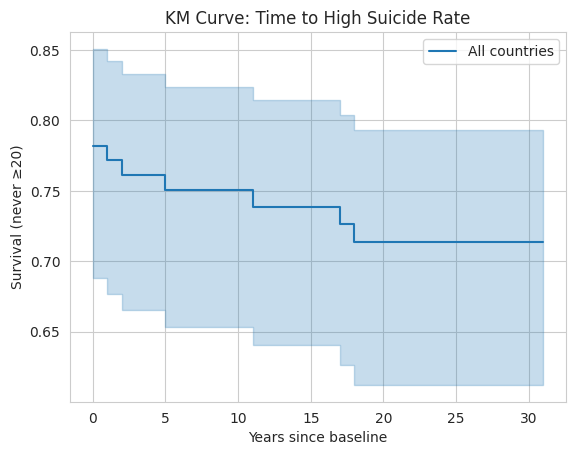

In [ ]:

# Fill life expectancy from avg values
surv = surv.merge(
    life_simple.rename(columns={'Country': 'country', 'life_expectancy': 'life_exp'}),
    on='country',
    how='left',
    suffixes=('', '_avg')
)
surv['life_exp'] = surv['life_exp'].fillna(surv['life_exp_avg'])
surv = surv.drop(columns=['life_exp_avg'])

# 3. Kaplan–Meier: overall
kmf = KaplanMeierFitter()
kmf.fit(surv['duration'], surv['event'], label='All countries')
ax = kmf.plot(ci_show=True)
ax.set_xlabel('Years since baseline')
ax.set_ylabel('Survival (never ≥20)')
plt.title('KM Curve: Time to High Suicide Rate')
plt.show()

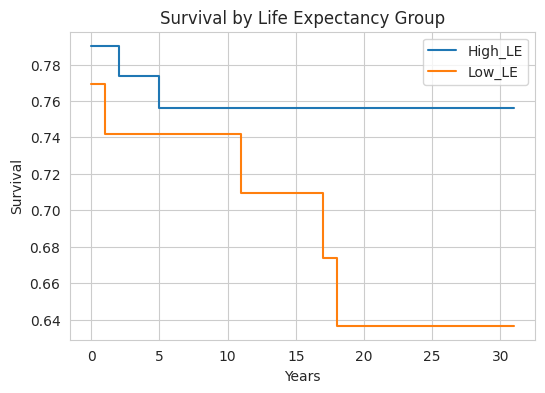

Log-rank p-value (Low vs High LE): 3.071e-01


In [ ]:
# 4. Stratify by life expectancy group (≥75 vs <75)
surv['le_grp'] = np.where(surv['life_exp'] >= 75, 'High_LE', 'Low_LE')
plt.figure(figsize=(6,4))
for grp_lbl, grp_df in surv.groupby('le_grp'):
    km = KaplanMeierFitter()
    km.fit(grp_df['duration'], grp_df['event'], label=grp_lbl)
    km.plot(ci_show=False)
plt.title('Survival by Life Expectancy Group')
plt.xlabel('Years')
plt.ylabel('Survival')
plt.show()

# Log-rank test
low = surv[surv['le_grp'] == 'Low_LE']
high = surv[surv['le_grp'] == 'High_LE']
res = logrank_test(low['duration'], high['duration'], low['event'], high['event'])
print(f'Log-rank p-value (Low vs High LE): {res.p_value:.3e}')


Fitting CoxPH on 73 rows (dropped 28 missing)


<lifelines.CoxPHFitter: fitted with 73 total observations, 55 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 73
number of events observed = 18
   partial log-likelihood = -74.32
         time fit was run = 2025-07-15 17:23:03 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
life_exp   0.05      1.06      0.07           -0.07            0.18                0.93                1.20

           cmp to    z    p  -log2(p)
covariate                            
life_exp     0.00 0.82 0.41      1.28
---
Concordance = 0.58
Partial AIC = 150.64
log-likelihood ratio test = 0.69 on 1 df
-log2(p) of ll-ratio test = 1.29

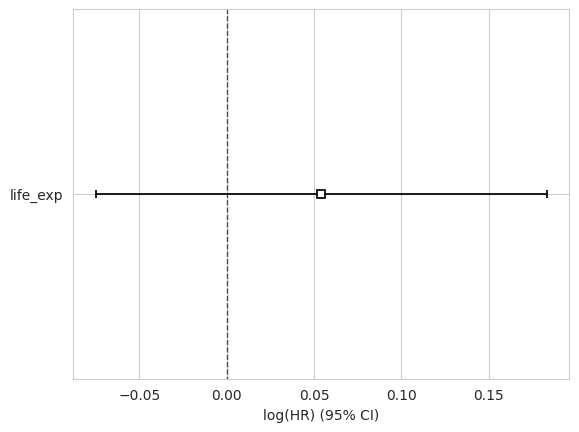

In [ ]:
# 5. Cox Proportional Hazards

# Drop any rows with missing covariates
cph_df = surv[['duration','event','life_exp']].dropna()

print(f"Fitting CoxPH on {len(cph_df)} rows (dropped {len(surv) - len(cph_df)} missing)")

cph = CoxPHFitter()
cph.fit(cph_df, duration_col='duration', event_col='event')
cph.print_summary()

# Plot the hazard ratios
cph.plot()
plt.show()


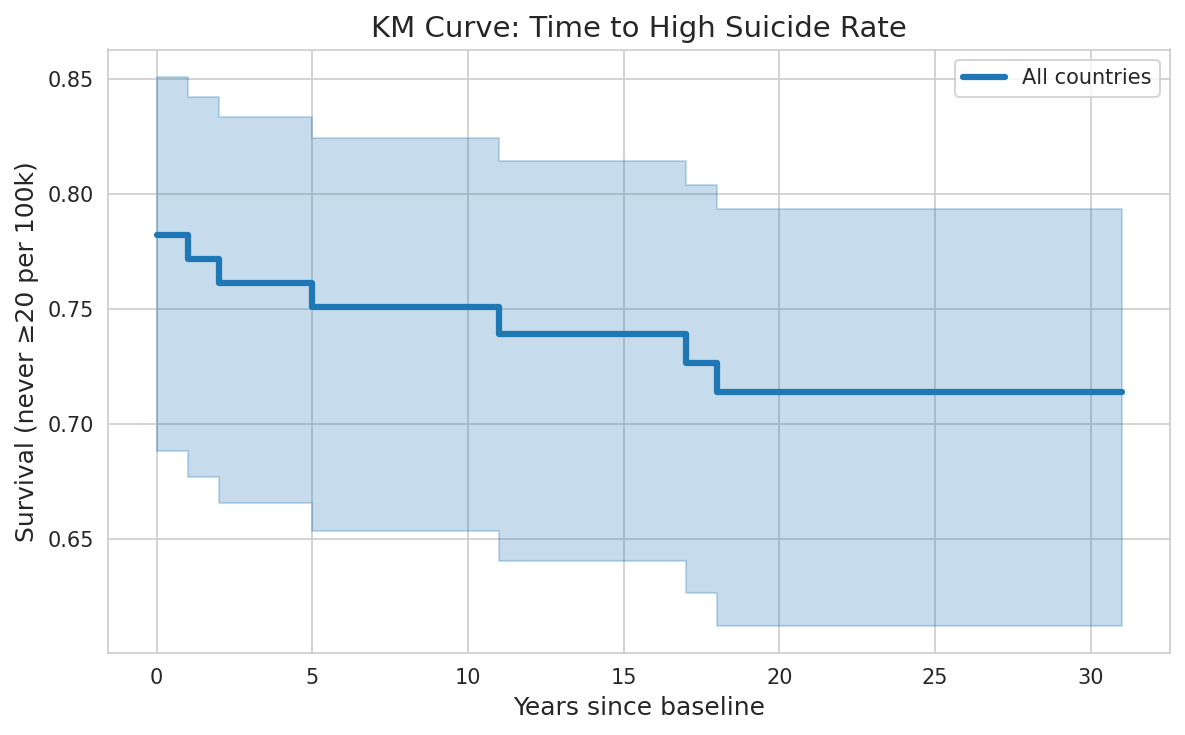

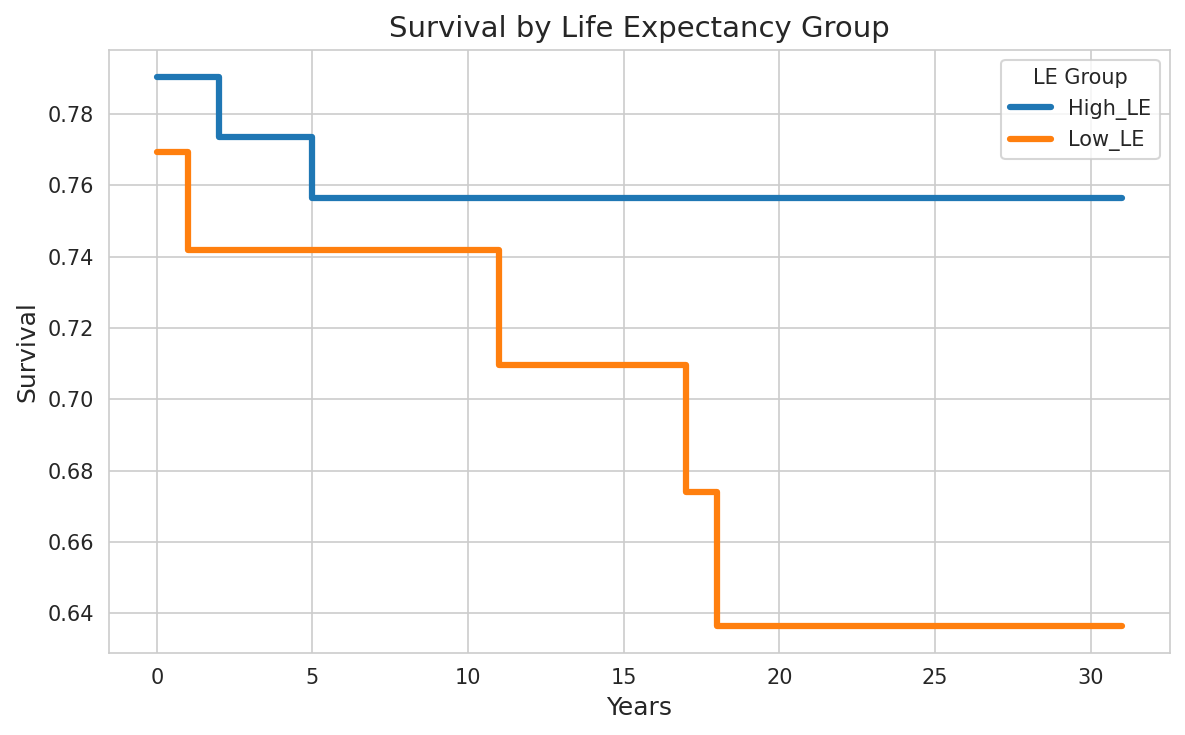

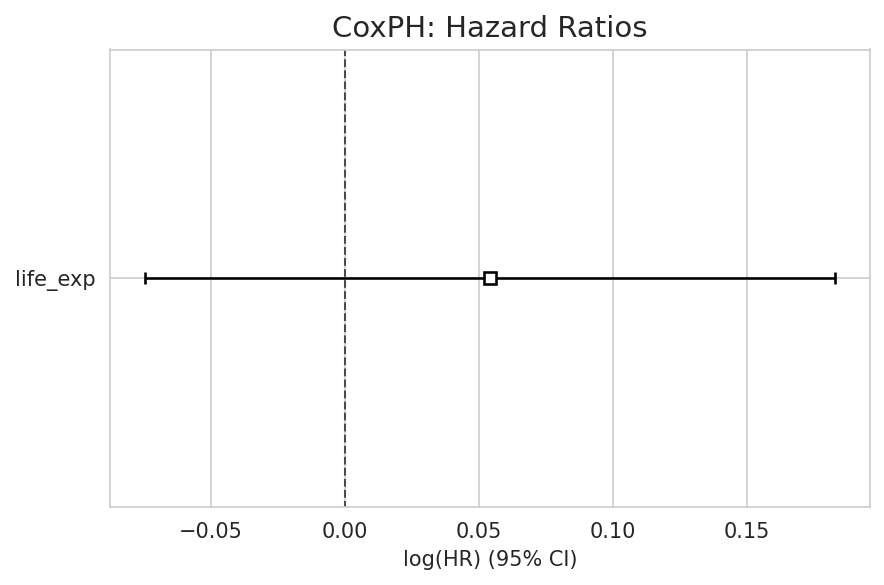

In [ ]:
# KM overall
plt.figure(figsize=(8,5), dpi=150)
kmf.plot(ci_show=True, linewidth=3)
plt.xlabel('Years since baseline', fontsize=12)
plt.ylabel('Survival (never ≥20 per 100k)', fontsize=12)
plt.title('KM Curve: Time to High Suicide Rate', fontsize=14)
plt.tight_layout()
plt.savefig('km_overall.png', bbox_inches='tight')
plt.show()

# KM stratified
plt.figure(figsize=(8,5), dpi=150)
for grp_lbl, grp_df in surv.groupby('le_grp'):
    km = KaplanMeierFitter()
    km.fit(grp_df['duration'], grp_df['event'], label=grp_lbl)
    km.plot(ci_show=False, linewidth=3)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Survival', fontsize=12)
plt.title('Survival by Life Expectancy Group', fontsize=14)
plt.legend(title='LE Group')
plt.tight_layout()
plt.savefig('km_stratified.png', bbox_inches='tight')
plt.show()

# Cox plot
plt.figure(figsize=(6,4), dpi=150)
cph.plot()
plt.title('CoxPH: Hazard Ratios', fontsize=14)
plt.tight_layout()
plt.savefig('cox_hr.png', bbox_inches='tight')
plt.show()


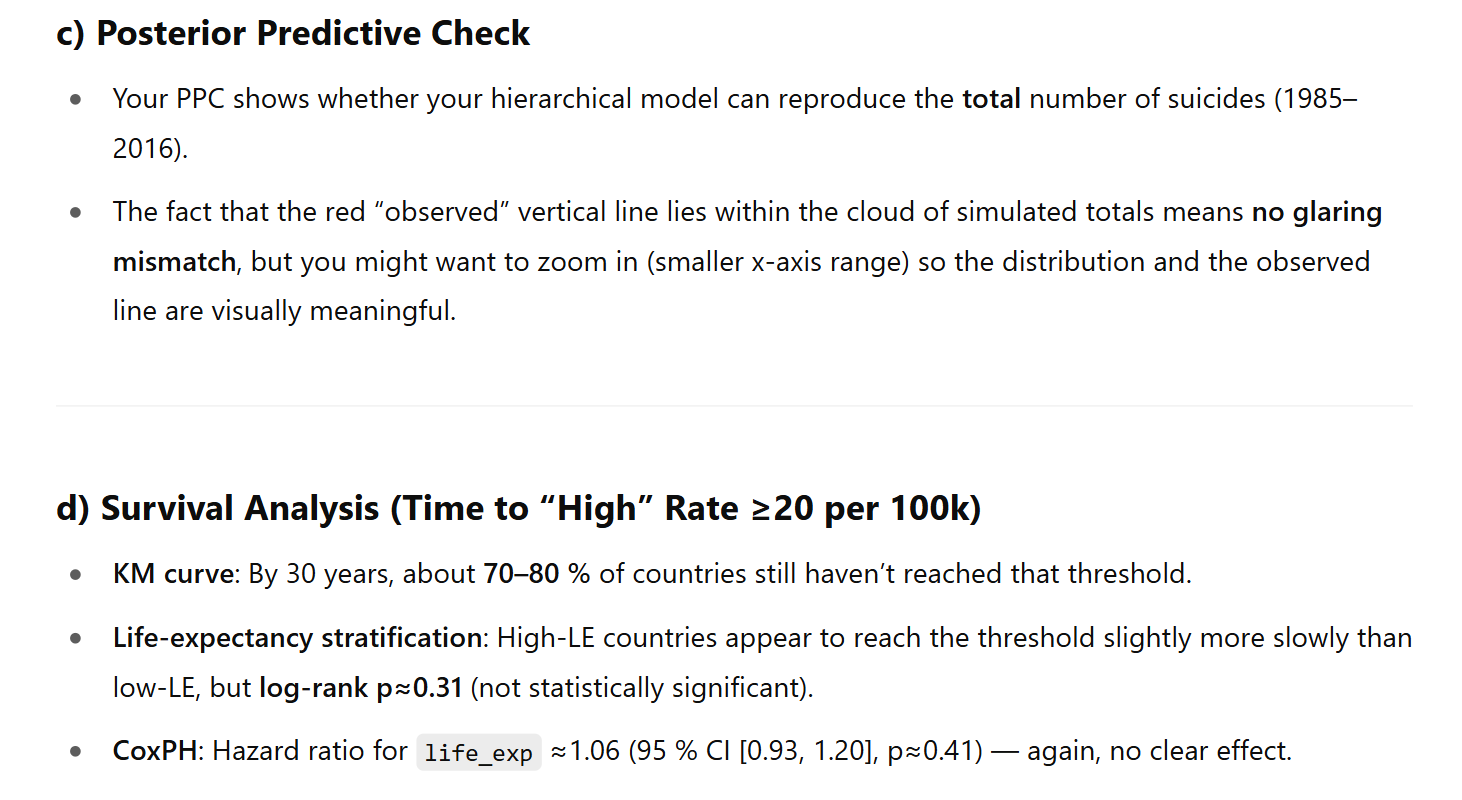

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# 1. Map regions
region_map = {
    'Armenia':'Europe', 'Austria':'Europe',
    # … your full map …
    'Thailand':'South-East Asia', 'Mauritius':'Africa'
}
df['region'] = df['country'].map(region_map).fillna('Other').astype('category')

# 2. Subset and drop any rows with missing data
model_df = df[['rate','sex_code','life_expectancy','text_suicidal_prop','region']].dropna()

# 3. Fit via formula (C(region) tells smf.ols to treat region as categorical)
model = smf.ols('rate ~ sex_code + life_expectancy + text_suicidal_prop + C(region)',
                data=model_df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     3.512
Date:                Tue, 15 Jul 2025   Prob (F-statistic):             0.0147
Time:                        17:25:14   Log-Likelihood:                -120.41
No. Observations:                  32   AIC:                             252.8
Df Residuals:                      26   BIC:                             261.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

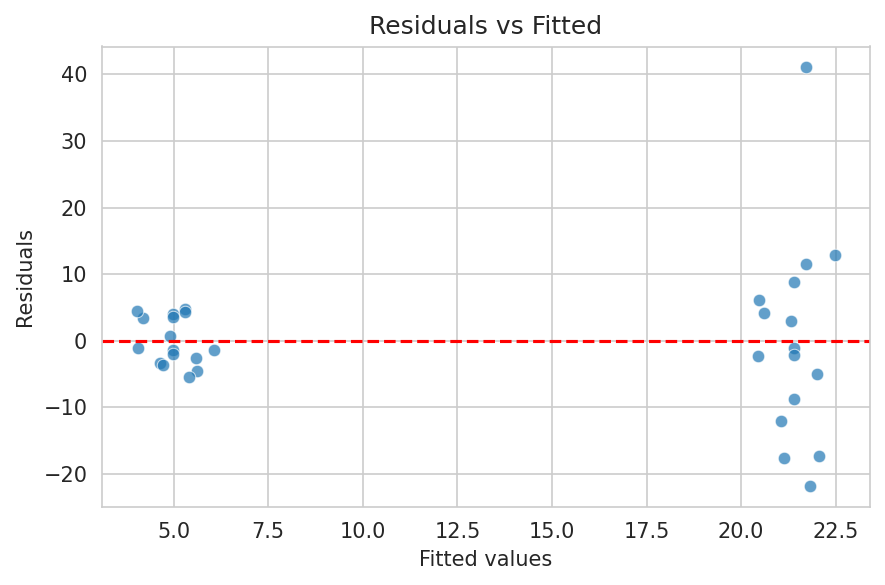

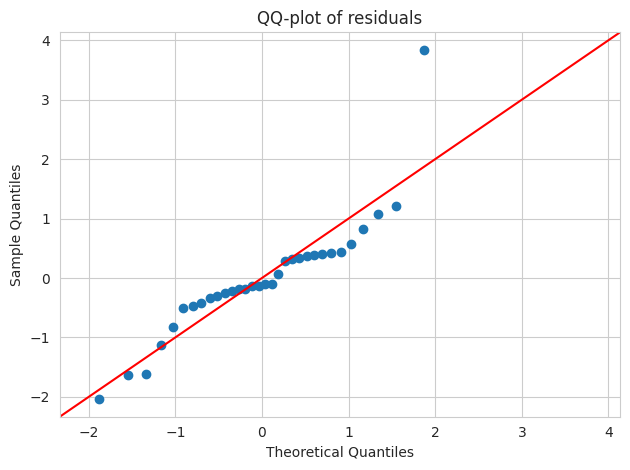

                 variable        VIF
0                sex_code   1.997912
1         life_expectancy  17.990829
2      text_suicidal_prop        NaN
3           region_Europe   3.135375
4            region_Other  13.757069
5  region_South-East Asia   2.058277


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# — assume `ols` and `X` are already defined from your OLS fit —

# 1. Residuals vs Fitted and QQ‐plot
resid   = ols.resid
fitted  = ols.fittedvalues

plt.figure(figsize=(6,4), dpi=150)
sns.scatterplot(x=fitted, y=resid, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.tight_layout()
plt.show()

sm.qqplot(resid, line='45', fit=True)
plt.title('QQ-plot of residuals')
plt.tight_layout()
plt.show()

# 2. Variance Inflation Factors
#    - drop the constant (no need to compute VIF on it)
#    - force everything else to float so no object dtypes remain
X_vif = X.drop(columns=['const'], errors='ignore').astype(float)

vif_df = pd.DataFrame({
    'variable': X_vif.columns,
    'VIF': [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])
    ]
})

print(vif_df)


In [ ]:
# --- prepare df_hier with life expectancy covariate ---
# (re-do your grouping & merge steps in one place)

# 1. aggregate suicides & pop
df_hier = (
    master
    .groupby(['country','year'])
    .agg(suicides_no=('suicides_no','sum'),
         population=('population','sum'))
    .reset_index()
)

# 2. merge in life expectancy (from your existing `life` DataFrame)
life_simple = (
    life[['Country','life_expectancy']]
    .rename(columns={'Country':'country'})
)
df_hier = df_hier.merge(life_simple, on='country', how='left')

# 3. drop any rows missing critical covariates
df_hier = df_hier.dropna(subset=['suicides_no','population','life_expectancy'])

# 4. factorize & standardize
df_hier['country_idx'], countries = pd.factorize(df_hier['country'])
df_hier['year_s'] = (df_hier['year'] - df_hier['year'].mean()) / df_hier['year'].std()
df_hier['le_s']   = (df_hier['life_expectancy'] - df_hier['life_expectancy'].mean()) / df_hier['life_expectancy'].std()

coords = {'country': countries}

with pm.Model(coords=coords) as hier_ext:
    mu_a         = pm.Normal('mu_a', mu=0, sigma=5)
    sigma_a      = pm.HalfNormal('sigma_a', sigma=5)
    a            = pm.Normal('a', mu=mu_a, sigma=sigma_a, dims='country')
    β_le_country = pm.Normal('β_le_country', mu=0, sigma=1)
    beta_year    = pm.Normal('beta_year', mu=0, sigma=1)

    log_lambda = (
        a[df_hier['country_idx'].values]
      + β_le_country * df_hier['le_s'].values
      + beta_year    * df_hier['year_s'].values
      + np.log(df_hier['population'].values)
    )

    deaths = pm.Poisson('deaths',
                        mu=pm.math.exp(log_lambda),
                        observed=df_hier['suicides_no'].values)

    trace_ext = pm.sample(3000, tune=1500,
                          target_accept=0.9,
                          random_seed=42)

print(az.summary(trace_ext,
                 var_names=['β_le_country','beta_year','sigma_a'],
                 hdi_prob=0.95))


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


               mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
β_le_country  0.227  0.126    -0.031      0.464      0.034    0.014      14.0   
beta_year    -0.002  0.000    -0.003     -0.001      0.000    0.000    7043.0   
sigma_a       1.044  0.092     0.875      1.230      0.002    0.001    3509.0   

              ess_tail  r_hat  
β_le_country      65.0   1.13  
beta_year       4545.0   1.00  
sigma_a         4436.0   1.00  


In [ ]:
# — assume you’ve already defined df_surv with columns ['country','year','rate']
#   and surv with one row per country (and columns ['country','life_exp','region']) —

import numpy as np
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

# 1. Threshold sweep: generate KM log-rank p-values at different cutoffs
def get_event(country, thresh):
    tmp = df_surv[df_surv['country'] == country].sort_values('year')
    rates = tmp['rate'].values
    years = tmp['year'].values
    above = np.where(rates >= thresh)[0]
    if len(above) > 0:
        return above[0], 1
    else:
        return len(years) - 1, 0

results = []
for thresh in [10, 15, 20, 25, 30]:
    rows = []
    for country in surv['country']:
        idx, ev = get_event(country, thresh)
        rows.append({'duration': idx, 'event': ev})
    ks = pd.DataFrame(rows)
    lr = logrank_test(
        ks.loc[ks.event == 0, 'duration'],
        ks.loc[ks.event == 1, 'duration'],
        event_observed_A=ks.loc[ks.event == 0, 'event'],
        event_observed_B=ks.loc[ks.event == 1, 'event']
    )
    results.append((thresh, lr.p_value))

print("Threshold vs log-rank p-value:", results)


# 2. Multivariable CoxPH for a chosen threshold (e.g. 20)
thresh = 20
durations, events = zip(*(get_event(c, thresh) for c in surv['country']))
surv2 = surv.copy()
surv2['duration'] = durations
surv2['event']    = events

# build Cox dataframe
cph_df2 = surv2[['duration','event','life_exp','region']].copy()
cph_df2 = pd.get_dummies(cph_df2, columns=['region'], drop_first=True).dropna()

cph2 = CoxPHFitter()
cph2.fit(cph_df2, duration_col='duration', event_col='event')
cph2.print_summary()


Threshold vs log-rank p-value: [(10, np.float64(5.827739365600851e-27)), (15, np.float64(2.4407692434586848e-29)), (20, np.float64(1.0455893940953511e-28)), (25, np.float64(2.2523710520285173e-32)), (30, np.float64(2.0442126608863206e-34))]


<lifelines.CoxPHFitter: fitted with 73 total observations, 55 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 73
number of events observed = 18
   partial log-likelihood = -74.25
         time fit was run = 2025-07-15 17:44:25 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
life_exp   0.05      1.05      0.07           -0.08            0.18                0.93                1.20

           cmp to    z    p  -log2(p)
covariate                            
life_exp     0.00 0.81 0.42      1.26
---
Concordance = 0.58
Partial AIC = 150.50
log-likelihood ratio test = 0.66 on 1 df
-log2(p) of ll-ratio test = 1.27

In [ ]:
# ============================================================================
# 1. Classical OLS inference & diagnostics
# ============================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# — assume `df` is your country‐sex DataFrame with columns:
#     ['rate','sex_code','life_expectancy','text_suicidal_prop','region'], all numeric or categorical
# — and that you’ve already fit
#     ols = sm.OLS(y, X).fit()

# 1.1. Point‐null tests for key coefficients
print("OLS p‐values:")
print(f"  sex_code:\t\t{ols.pvalues['sex_code']:.3g}")
print(f"  life_expectancy:\t{ols.pvalues['life_expectancy']:.3g}")
print(f"  text_suicidal_prop:\t{ols.pvalues['text_suicidal_prop']:.3g}")

# 1.2. 95% confidence intervals
print("\n95% CIs:")
print(ols.conf_int().loc[['sex_code','life_expectancy','text_suicidal_prop']])

# 1.3. Joint F‐test for all region dummies using formula API
df_model = df[['rate','sex_code','life_expectancy','text_suicidal_prop','region']].dropna()
formula_mod = smf.ols('rate ~ sex_code + life_expectancy + text_suicidal_prop + C(region)',
                      data=df_model).fit()
anova_res = anova_lm(formula_mod, typ=2)
print(f"\nRegion omnibus F‐test p‐value: {anova_res.loc['C(region)','PR(>F)']:.3g}")

# 1.4. Normality of residuals (Shapiro–Wilk)
sw_stat, sw_p = shapiro(ols.resid)
print(f"\nShapiro‐Wilk p‐value: {sw_p:.3g}")

# 1.5. Homoscedasticity (Breusch–Pagan)
bp_stat, bp_p, _, _ = het_breuschpagan(ols.resid, ols.model.exog)
print(f"Breusch–Pagan p‐value: {bp_p:.3g}")

# 1.6. Multicollinearity (VIF) — drop intercept
X_vif = X.drop(columns=['const'], errors='ignore').astype(float)
vif_df = pd.DataFrame({
    'variable': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i)
            for i in range(X_vif.shape[1])]
})
print("\nVIFs:")
print(vif_df)

# ============================================================================
# 2. Bayesian hierarchical model inference & comparison
# ============================================================================

import arviz as az

# — assume you have two inference data objects:
#     trace2     (base model without life_exp covariate)
#     trace_ext  (extended model with β_le_country)
# — and you want posterior summaries & probabilities

# 2.1. Posterior summaries (95% HDIs)
print("\nBayesian posterior summaries (95% HDI):")
print(az.summary(trace_ext,
                 var_names=['beta_year','β_le_country','sigma_a'],
                 hdi_prob=0.95))

# 2.2. Posterior probability β < 0 or > 0
for var in ['beta_year','β_le_country']:
    samples = trace_ext.posterior[var].values.flatten()
    p_lt0 = (samples < 0).mean()
    print(f"P({var} < 0) = {p_lt0:.3f}")

# 2.3. Model comparison via LOO
loo_base = az.loo(trace2, pointwise=False)
loo_ext  = az.loo(trace_ext, pointwise=False)
comp_df  = az.compare({'base': trace2, 'extended': trace_ext},
                     ic='loo',
                     scale='deviance')
print("\nLOO model comparison:")
print(comp_df)

# ============================================================================
# 3. Survival/threshold & CoxPH inference
# ============================================================================

from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

# — assume you ran the threshold sweep and have:
#     results  = [(thresh, p_value), ...]
# — and that surv2 is your DataFrame with ['duration','event','life_exp','region*'] ready

print("\nThreshold vs. log‐rank p‐values:")
for thresh, p in results:
    print(f"  cutoff={thresh}: p={p:.3g}")

# 3.1. CoxPH model (for your chosen threshold)
cph = CoxPHFitter()
cph.fit(cph_df2, duration_col='duration', event_col='event')
print("\nCoxPH summary:")
cph.print_summary()

# 3.2. Extract hazard ratios & 95% CIs
hr = pd.DataFrame({
    'HR': np.exp(cph.params_),
    'lower95': np.exp(cph.confidence_intervals_['lower-bound']),
    'upper95': np.exp(cph.confidence_intervals_['upper-bound']),
})
print("\nHazard ratios (95% CI):")
print(hr)


OLS p‐values:
  sex_code:		0.000278
  life_expectancy:	0.782
  text_suicidal_prop:	nan

95% CIs:
                           0          1
sex_code            8.292256  24.535701
life_expectancy    -1.781199   1.353719
text_suicidal_prop  0.000000   0.000000

Region omnibus F‐test p‐value: 0.716

Shapiro‐Wilk p‐value: 0.000759
Breusch–Pagan p‐value: 0.194

VIFs:
                 variable        VIF
0                sex_code   1.997912
1         life_expectancy  17.990829
2      text_suicidal_prop        NaN
3           region_Europe   3.135375
4            region_Other  13.757069
5  region_South-East Asia   2.058277

Bayesian posterior summaries (95% HDI):
               mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_year    -0.002  0.000    -0.003     -0.001      0.000    0.000    7043.0   
β_le_country  0.227  0.126    -0.031      0.464      0.034    0.014      14.0   
sigma_a       1.044  0.092     0.875      1.230      0.002    0.001    3509.0   

            

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '


TypeError: log likelihood not found in inference data object